1. Import the necessary libraries

In [121]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

import os
print(os.listdir("/content/drive/MyDrive/chest_xray"))

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import time
import copy
import torchvision.transforms as transforms


['chest_xray']


2. Read the dataset

In [123]:
from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/chest_xray/chest_xray"]).decode("utf8"))

test
train
val



In [125]:
# Definición de las rutas de los directorios de datos. 
# Estos son directorios en un sistema de archivos que contienen las imágenes de rayos X para entrenamiento, validación y pruebas.
datadir = '/content/drive/MyDrive/chest_xray/chest_xray'
traindir = datadir + '/train/'
validdir = datadir + '/val/'
testdir = datadir + '/test/'

# Establece los nombres de archivo para el modelo guardado y el punto de control del modelo. 
# Un punto de control del modelo es una instantánea del estado de un modelo de aprendizaje profundo en un momento determinado durante su entrenamiento.
save_file_name = 'vgg16-chest-4.pt'
checkpoint_path = 'vgg16-chest-4.pth'

# Define el tamaño de lote para el entrenamiento. 
# El tamaño de lote es el número de ejemplos de entrenamiento utilizados en una iteración del proceso de entrenamiento.
batch_size = 128

# Comprueba si una GPU está disponible para el entrenamiento. 
# Si una GPU está disponible, se usará para acelerar el proceso de entrenamiento.
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Si se dispone de una GPU, averigua cuántas hay disponibles.
# Si hay más de una GPU, entonces se utilizará el entrenamiento multi-GPU, que puede acelerar aún más el proceso de entrenamiento.
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


Train on gpu: True
1 gpus detected.


3. Exploration of the data

<Axes: xlabel='category'>

(array([0, 1]), [Text(0, 0, 'NORMAL'), Text(1, 0, 'PNEUMONIA')])

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Training Images by Category')

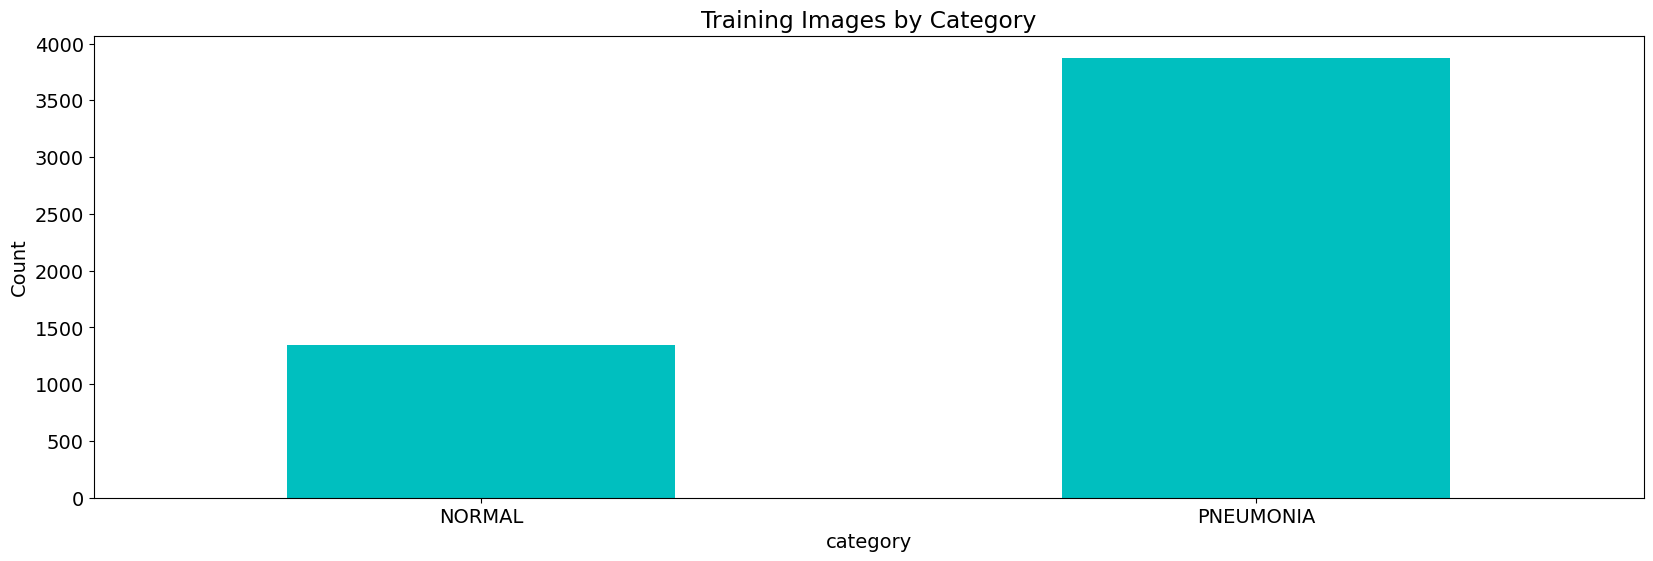

In [126]:
# Se inicializan listas vacías para almacenar diversas estadísticas.
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Se itera a través de cada categoría en el directorio de entrenamiento.
# Cada categoría es un subdirectorio en el directorio de entrenamiento.
for d in os.listdir(traindir):
    if not d.startswith('.'):
        # Se guarda la categoría (nombre del directorio)
        categories.append(d)

        # Se recopilan las imágenes en cada directorio (categoría) para los conjuntos de entrenamiento, validación y prueba.
        # Se guardan las cantidades de imágenes en cada categoría.
        train_imgs = os.listdir(traindir + d)
        valid_imgs = os.listdir(validdir + d)
        test_imgs = os.listdir(testdir + d)
        n_train.append(len(train_imgs))
        n_valid.append(len(valid_imgs))
        n_test.append(len(test_imgs))

        # Se encuentra las estadísticas para las imágenes de entrenamiento, es decir, su altura y anchura.
        for i in train_imgs:
            if not i.startswith('.'):
                img_categories.append(d)
                img = Image.open(traindir + d + '/' + i)
                img_array = np.array(img)
                # Se guardan las dimensiones de las imágenes
                hs.append(img_array.shape[0])
                ws.append(img_array.shape[1])

# Se crea un DataFrame con los números de imágenes en cada categoría para los conjuntos de entrenamiento, validación y prueba.
cat_df = pd.DataFrame({'category': categories, 'n_train': n_train, 'n_valid': n_valid, 'n_test': n_test}).sort_values('category')

# Se crea otro DataFrame con las dimensiones de las imágenes de entrenamiento en cada categoría.
image_df = pd.DataFrame({'category': img_categories, 'height': hs, 'width': ws})

# Se crea un gráfico de barras para visualizar el número de imágenes de entrenamiento en cada categoría.
cat_df.set_index('category')['n_train'].plot.bar(color='c', figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category')

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='height', ylabel='Density'>

<Axes: xlabel='height', ylabel='Density'>

Text(0.5, 0, 'Pixels')

Text(0, 0.5, 'Density')

Text(0.5, 1.0, 'Average Size Distribution')

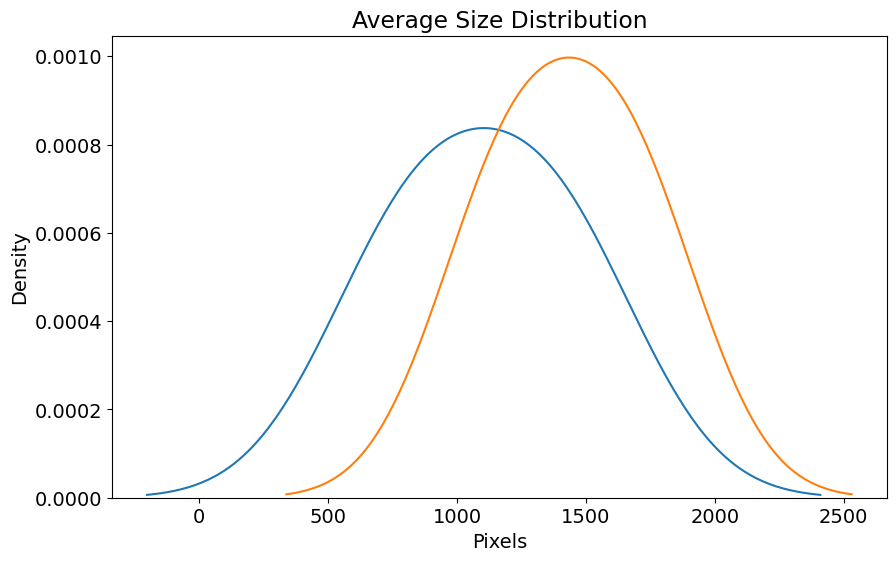

In [127]:
# Se calcula el tamaño promedio (altura y anchura) de las imágenes en cada categoría. 
# El método groupby agrupa el DataFrame por categoría, y el método mean calcula el promedio.
img_dsc = image_df.groupby('category').mean()

# Se inicializa una nueva figura para el gráfico con un tamaño específico.
plt.figure(figsize=(10, 6))

# Se crea un gráfico de densidad de Kernel (KDE) para la altura promedio de las imágenes. 
# Un gráfico KDE es una forma de visualizar la distribución de una variable continua.
sns.kdeplot(img_dsc['height'], label='Average Height')

# Se crea un gráfico KDE para la anchura promedio de las imágenes.
sns.kdeplot(img_dsc['width'], label='Average Width')

# Se establecen las etiquetas de los ejes x e y del gráfico.
plt.xlabel('Pixels')
plt.ylabel('Density')

# Se establece el título del gráfico.
plt.title('Average Size Distribution')

In [128]:
def imshow(image):
    """Display image"""
    # Se inicializa una nueva figura para mostrar la imagen. El tamaño de la figura es 6x6.
    plt.figure(figsize=(6, 6))
    
    # Se utiliza el método imshow() de matplotlib para visualizar la imagen. 
    plt.imshow(image)
    
    # Se desactivan los ejes de la figura. Esto significa que no se mostrarán las marcas de los ejes ni los números alrededor de la imagen.
    plt.axis('off')
    
    # Se muestra la figura con la imagen.
    plt.show()

(1013, 1528)

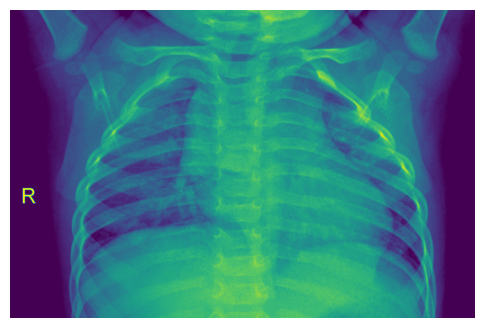

In [129]:
# Abre una imagen de la carpeta 'NORMAL' dentro del directorio de entrenamiento usando la función open() de la clase Image en PIL (Python Imaging Library)
# La ruta completa de la imagen se forma concatenando el directorio de entrenamiento, la subcarpeta 'NORMAL' y el nombre de la imagen
x = Image.open(traindir + 'NORMAL/IM-0128-0001.jpeg')

# Convierte la imagen abierta en un array de NumPy y obtiene la forma (dimensiones) de la imagen
# Nota: este código por sí solo no imprimirá la forma. Si deseas ver las dimensiones, puedes utilizar print(np.array(x).shape)
np.array(x).shape

# Utiliza la función imshow() que definimos anteriormente para visualizar la imagen
imshow(x)

(863, 1244)

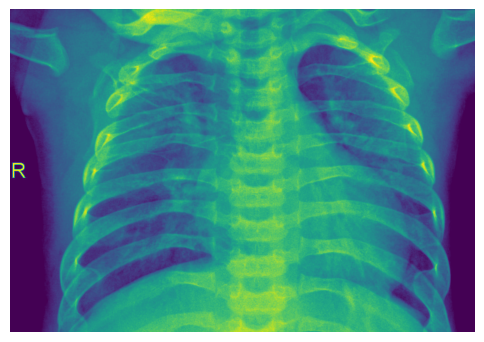

In [130]:
# Abre una imagen de la carpeta 'PNEUMONIA' en el directorio de entrenamiento utilizando la función open() de la clase Image en PIL (Python Imaging Library).
# La ruta completa de la imagen se forma concatenando el directorio de entrenamiento, la subcarpeta 'PNEUMONIA', y el nombre de la imagen.
x = Image.open(traindir + 'PNEUMONIA/person1001_bacteria_2932.jpeg')

# Convierte la imagen abierta a un array de NumPy y obtiene la forma (dimensiones) de la imagen.
# Nota: este código por sí solo no imprimirá la forma. Si deseas ver las dimensiones, puedes utilizar print(np.array(x).shape).
np.array(x).shape

# Usa la función imshow() que definimos anteriormente para visualizar la imagen.
imshow(x)

4. Image Preprocessing and Data Augmentation

In [131]:
# Diccionario para las transformaciones de las imágenes
image_transforms = {
    # Transformaciones para las imágenes de entrenamiento
    'train':
    transforms.Compose([
        # Recorte aleatorio a tamaño 256 con una escala entre 0.8 y 1.0
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # Rotación aleatoria de la imagen en un rango de -15 a 15 grados
        transforms.RandomRotation(degrees=15),
        # Cambio aleatorio del brillo, contraste y saturación de la imagen
        transforms.ColorJitter(),
        # Volteo horizontal aleatorio de la imagen
        transforms.RandomHorizontalFlip(),
        # Recorte al centro de la imagen a un tamaño de 224 (estándares de ImageNet)
        transforms.CenterCrop(size=224),
        # Conversión de la imagen a un tensor
        transforms.ToTensor(),
        # Normalización de la imagen con los valores medios y de desviación estándar de ImageNet
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]) 
    ]),
    # Transformaciones para las imágenes de validación
    'val':
    transforms.Compose([
        # Cambio de tamaño a 256
        transforms.Resize(size=256),
        # Recorte al centro a un tamaño de 224
        transforms.CenterCrop(size=224),
        # Conversión de la imagen a un tensor
        transforms.ToTensor(),
        # Normalización de la imagen con los valores medios y de desviación estándar de ImageNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Transformaciones para las imágenes de prueba
    'test':
    transforms.Compose([
        # Cambio de tamaño a 256
        transforms.Resize(size=256),
        # Recorte al centro a un tamaño de 224
        transforms.CenterCrop(size=224),
        # Conversión de la imagen a un tensor
        transforms.ToTensor(),
        # Normalización de la imagen con los valores medios y de desviación estándar de ImageNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [132]:
# Función para visualizar un tensor de imagen
def imshow_tensor(image, ax=None, title=None):
    # Si no se proporciona un eje (ax), crea un nuevo conjunto de figura y eje
    if ax is None:
        fig, ax = plt.subplots()

    # Reorganiza las dimensiones del tensor de imagen para que el canal de color sea la tercera dimensión
    image = image.numpy().transpose((1, 2, 0))

    # Invierte las etapas de preprocesamiento
    # Añade la media y multiplica por la desviación estándar (valores de ImageNet)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Corta los valores de los píxeles de la imagen para que estén en el rango [0, 1]
    image = np.clip(image, 0, 1)

    # Muestra la imagen en el eje
    ax.imshow(image)
    # Desactiva los ejes
    plt.axis('off')

    # Retorna el eje y la imagen
    return ax, image

5. Data Iterators
Para evitar cargar todos los datos en la memoria a la vez, utilizamos DataLoaders de entrenamiento. Primero, creamos un objeto de conjunto de datos a partir de las carpetas de imágenes, y luego pasamos estos a un DataLoader.

In [133]:
# Creación de diccionarios de datasets. Aquí cargamos las imágenes de las carpetas especificadas y aplicamos las transformaciones de imagen que definimos previamente.
data = {
    # Conjunto de entrenamiento
    'train': datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    # Conjunto de validación
    'val': datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    # Conjunto de prueba
    'test': datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Creación de dataloaders - estos manejarán el cargado de las imágenes en lotes (batch) durante el entrenamiento
dataloaders = {
    # Dataloader para el conjunto de entrenamiento
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    # Dataloader para el conjunto de validación
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    # Dataloader para el conjunto de prueba
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}


In [134]:
# Creación de un iterador para el dataloader de entrenamiento. Esto nos permitirá iterar a través de los lotes de imágenes y etiquetas en el conjunto de datos de entrenamiento.
trainiter = iter(dataloaders['train'])

# Usamos el iterador para obtener el próximo (en este caso, el primero) lote de imágenes y etiquetas del conjunto de entrenamiento.
features, labels = next(trainiter)

# Imprimimos las dimensiones de las imágenes y las etiquetas para ver la estructura de nuestros datos. 
# features.shape nos da el tamaño del lote y las dimensiones de las imágenes y labels.shape nos da el número de etiquetas en el lote.
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [135]:
# 'cat_df' es un DataFrame que contiene las categorías de las imágenes en el conjunto de datos.
# Obtenemos el número total de clases (categorías) utilizando la función len() en 'cat_df'.
n_classes = len(cat_df)

# Imprimimos el número total de clases en nuestro conjunto de datos.
print(f'There are {n_classes} different classes.')

# También obtenemos el número de clases directamente del conjunto de datos de entrenamiento. 
# 'data' es un diccionario que contiene nuestros conjuntos de datos (entrenamiento, validación, prueba).
# 'data['train'].classes' nos da una lista de las clases en el conjunto de datos de entrenamiento.
# La función len() aplicada a esta lista nos da el número de clases únicas en el conjunto de entrenamiento.
len(data['train'].classes)

There are 2 different classes.


2

6. Using Pre-Trained Models for Image Classifications

Approach:

a. Cargamos los pesos pre-entrenados de una red entrenada en un gran conjunto de datos.

b. Congelamos todos los pesos en las capas inferiores (convolucionales).

c. Las capas a congelar se pueden ajustar dependiendo de la similitud de la tarea con el gran conjunto de datos de entrenamiento.

d. Reemplazamos la parte del clasificador (completamente conectada) de la red con un clasificador personalizado.

e. El número de salidas debe establecerse igual al número de clases.

f. Entrenamos solo las capas del clasificador personalizado (totalmente conectado) para la tarea.

g. Optimizamos el modelo del clasificador para un conjunto de datos más pequeño.

### ***VGG16***

In [136]:
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [137]:
# Iteramos sobre todos los parámetros del modelo
for param in model.parameters():
    # Marcamos los parámetros para que no se calculen gradientes
    param.requires_grad = False  # Congelamos los parámetros, no se actualizarán durante el entrenamiento

Agregar un clasificador personalizado. Vamos a entrenar un clasificador que consiste en las siguientes capas:

a. Completamente conectada con activación ReLU (n_inputs, 256)

b. Dropout con 40% de probabilidad de exclusión

c. Completamente conectada con salida log softmax (256, n_classes)

In [138]:
# Obtenemos el número de características de entrada de la última capa del clasificador
n_inputs = model.classifier[6].in_features

# Reemplazamos la última capa del clasificador con una nueva secuencia de módulos
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),  # Capa lineal que transforma las características de entrada a 256
    nn.ReLU(),  # Función de activación ReLU
    nn.Dropout(0.4),  # Capa de dropout con una probabilidad de 0.4
    nn.Linear(256, n_classes),  # Capa lineal que transforma las 256 características a n_classes
    nn.LogSoftmax(dim=1)  # Función de activación LogSoftmax
)

# Imprimimos el nuevo clasificador
print(model.classifier)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)


In [139]:
# Calcula y muestra el número total de parámetros en el modelo
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

# Calcula y muestra el número de parámetros que se entrenarán
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
1,049,346 training parameters.


Moving to GPU

In [140]:
model = model.to('cuda')

Carga del modelo pre-entrenado

In [141]:
def get_pretrained_model(model_name):
    """
    Recupera un modelo preentrenado de torchvision

    Parámetros
    -------
        model_name (str): nombre del modelo (actualmente solo acepta vgg16 y resnet50)

    Devuelve
    --------
        model (modelo PyTorch): cnn

    """

    # Si el nombre del modelo es 'vgg16'
    if model_name == 'vgg16':
        # Carga el modelo preentrenado vgg16
        model = models.vgg16(pretrained=True)

        # Congela las primeras capas
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Añade un clasificador personalizado
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # # Si el nombre del modelo es 'resnet50'
    # elif model_name == 'resnet50':
    #     # Carga el modelo preentrenado resnet50
    #     model = models.resnet50(pretrained=True)

    #     # Congela las primeras capas
    #     for param in model.parameters():
    #         param.requires_grad = False

    #     # Obtiene el número de características de entrada de la capa completamente conectada
    #     n_inputs = model.fc.in_features
    #     # Reemplaza la capa completamente conectada con un clasificador personalizado
    #     model.fc = nn.Sequential(
    #         nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
    #         nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Si se va a entrenar en GPU, mueve el modelo a la GPU
    if train_on_gpu:
        model = model.to('cuda')

    # Si se va a entrenar en múltiples GPUs, paraleliza el modelo
    if multi_gpu:
        model = nn.DataParallel(model)

    # Devuelve el modelo
    return model

In [142]:
# Obtiene una versión preentrenada del modelo 'vgg16'
model = get_pretrained_model('vgg16')

# Si se está utilizando múltiples GPUs
# if multi_gpu:
#     # Imprime un resumen del modelo, accediendo al modelo original a través de 'model.module'
#     summary(
#         model.module,  # modelo original
#         input_size=(3, 224, 224),  # tamaño de entrada esperado
#         batch_size=batch_size,  # tamaño del lote
#         device='cuda'  # dispositivo en el que se ejecuta el modelo
#     )
# Si no se está utilizando múltiples GPUs
# else:
    # Imprime un resumen del modelo
summary(
    model,  # modelo
    input_size=(3, 224, 224),  # tamaño de entrada esperado
    batch_size=batch_size,  # tamaño del lote
    device='cuda'  # dispositivo en el que se ejecuta el modelo
  )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 256, 56, 56]         590,080
             ReLU-14         [128, 256,

Asignación de clases a índices

In [143]:
# Asignamos el mapeo de clases a índices del conjunto de datos de entrenamiento al modelo
model.class_to_idx = data['train'].class_to_idx

# Creamos un mapeo inverso de índices a clases y lo asignamos al modelo
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

# Imprimimos la lista de pares (índice, clase) en el modelo
list(model.idx_to_class.items())

[(0, 'NORMAL'), (1, 'PNEUMONIA')]

Training Loss and Optimizer:

La pérdida es la logaritmo negativo de la verosimilitud y el optimizador es el optimizador Adam.

In [144]:
# Establecer la función de pérdida como la log verosimilitud negativa
criterion = nn.NLLLoss()
# Establecer el optimizador como Adam y pasarle los parámetros del modelo a optimizar
optimizer = optim.Adam(model.parameters())

# Iterar a través de los parámetros que van a ser optimizados
for p in optimizer.param_groups[0]['params']:
    # Si el parámetro requiere un gradiente (es decir, se va a optimizar)
    if p.requires_grad:
        # Imprimir la forma del parámetro
        print(p.shape)


torch.Size([256, 4096])
torch.Size([256])
torch.Size([2, 256])
torch.Size([2])


7. Training the model

Para el entrenamiento, iteramos a través del DataLoader de entrenamiento, pasando un lote a través del modelo cada vez. Un pase completo a través de los datos de entrenamiento se conoce como una época, y entrenamos durante un número determinado de épocas o hasta que se active la detención temprana (más adelante). Después de cada lote, calculamos la pérdida (con criterion(output, targets)) y luego calculamos los gradientes de la pérdida con respecto a los parámetros del modelo con loss.backward(). Esto utiliza autodiferenciación y retropropagación para calcular los gradientes.

Después de calcular los gradientes, llamamos a optimizer.step() para actualizar los parámetros del modelo con los gradientes. Esto se hace en cada lote de entrenamiento, por lo que estamos implementando el descenso de gradiente estocástico (o más bien una versión de él con momentum conocida como Adam). Para cada lote, también calculamos la precisión para el monitoreo y después de que se ha completado el ciclo de entrenamiento, iniciamos el ciclo de validación. Esto se utilizará para llevar a cabo la detención temprana.

In [145]:
from timeit import default_timer as timer

def train(model, criterion, optimizer, train_loader, valid_loader, save_file_name, max_epochs_stop=3, n_epochs=20, print_every=2):
    """Entrena un modelo PyTorch

    Parámetros
    --------
        model (PyTorch model): cnn a entrenar
        criterion (Pérdida de PyTorch): objetivo a minimizar
        optimizer (Optimizador de PyTorch): optimizador para calcular los gradientes de los parámetros del modelo
        train_loader (PyTorch dataloader): dataloader de entrenamiento para iterar
        valid_loader (PyTorch dataloader): dataloader de validación utilizado para detención temprana
        save_file_name (str terminado en '.pt'): ruta de archivo para guardar el estado del modelo
        max_epochs_stop (int): número máximo de épocas sin mejora en la pérdida de validación para detener temprano
        n_epochs (int): número máximo de épocas de entrenamiento
        print_every (int): frecuencia de épocas para imprimir estadísticas de entrenamiento

    Devoluciones
    --------
        model (PyTorch model): cnn entrenado con los mejores pesos
        history (DataFrame): historial de pérdida y precisión de entrenamiento y validación
        train_loss_list (list): lista de pérdida de entrenamiento en cada iteración
        valid_loss_list (list): lista de pérdida de validación en cada iteración
        train_acc_list (list): lista de precisión de entrenamiento en cada iteración
        valid_acc_list (list): lista de precisión de validación en cada iteración
    """
    # Inicialización de la detención temprana
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []
    
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []

    # Número de épocas ya entrenadas (si se usan pesos de modelo cargados)
    try:
        print(f'El modelo ha sido entrenado durante: {model.epochs} épocas.\n')
    except:
        model.epochs = 0
        print(f'Iniciando entrenamiento desde cero.\n')

    overall_start = timer()

    # Bucle principal
    for epoch in range(n_epochs):
        # mantén un registro de la pérdida de entrenamiento y validación en cada época
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Cambiar a modo de entrenamiento
        model.train()
        start = timer()

        # Bucle de entrenamiento
        for ii, (data, target) in enumerate(train_loader):
            # Tensores a gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Borrar gradientes
            optimizer.zero_grad()
            # Las salidas predichas son log probabilidades
            output = model(data)

            # Pérdida y retropropagación de gradientes
            loss = criterion(output, target)
            loss.backward()

            # Actualizar los parámetros
            optimizer.step()

            # Seguimiento de la pérdida de entrenamiento multiplicando la pérdida promedio por el número de ejemplos en el lote
            train_loss += loss.item() * data.size(0)

            # Calcular la precisión encontrando la máxima probabilidad de log
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

            # Necesita convertir el tensor correcto de int a float para promediar
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiplica la precisión promedio por el número de ejemplos en el lote
            train_acc += accuracy.item() * data.size(0)
            
            # Seguimiento del progreso de entrenamiento
            print(f'Época: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% completado. {timer() - start:.2f} segundos transcurridos en la época.', end='\r')

        # Después de que termina el ciclo de entrenamiento, comienza la validación
        else:
            model.epochs += 1

            # No necesitas hacer seguimiento de los gradientes
            with torch.no_grad():
                # Cambiar al modo de evaluación
                model.eval()

                # Bucle de validación
                for data, target in valid_loader:
                    # Tensores a gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Paso adelante
                    output = model(data)

                    # Pérdida de validación
                    loss = criterion(output, target)
                    # Multiplica la pérdida promedio por el número de ejemplos en el lote
                    valid_loss += loss.item() * data.size(0)

                    # Calcula la precisión de validación
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    # Multiplica la precisión promedio por el número de ejemplos
                    valid_acc += accuracy.item() * data.size(0)

                # Calcula las pérdidas promedio
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calcula la precisión promedio
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)
                
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                train_acc_list.append(train_acc)
                valid_acc_list.append(valid_acc)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Imprimir los resultados de entrenamiento y validación
                if (epoch + 1) % print_every == 0:
                    print(f'\nÉpoca: {epoch} \tPérdida de entrenamiento: {train_loss:.4f} \tPérdida de validación: {valid_loss:.4f}')
                    print(f'\t\tPrecisión de entrenamiento: {100 * train_acc:.2f}%\t Precisión de validación: {100 * valid_acc:.2f}%')

                # Guarda el modelo si la pérdida de validación disminuye
                if valid_loss < valid_loss_min:
                    # Guardar modelo
                    torch.save(model.state_dict(), save_file_name)
                    # Seguimiento de la mejora
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # De lo contrario incrementa el recuento de épocas sin mejora
                else:
                    epochs_no_improve += 1
                    
                    # Detención temprana
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\n¡Detención temprana! Épocas totales: {epoch}. Mejor época: {best_epoch} con pérdida: {valid_loss_min:.2f} y precisión: {100 * valid_best_acc:.2f}%')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} segundos totales transcurridos. {total_time / (epoch+1):.2f} segundos por época.')

                        # Carga el mejor estado dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Actualiza los valores de valid_loss_min, valid_best_acc y best_epoch
                        valid_loss_min = min(valid_loss_list)
                        best_epoch = valid_loss_list.index(valid_loss_min)

                        # Adjunta el optimizador
                        model.optimizer = optimizer

                        # Formato del historial
                        history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
                        return model, history, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

    # Adjunta el optimizador
    model.optimizer = optimizer
    # Registra el tiempo total e imprime las estadísticas
    total_time = timer() - overall_start
    print(f'\nMejor época: {best_epoch} con pérdida: {valid_loss_min:.2f} y precisión: {100 * valid_best_acc:.2f}%')
    print(f'{total_time:.2f} segundos totales transcurridos. {total_time / (epoch):.2f} segundos por época.')
    # Formato del historial
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

In [146]:
# Entrenamiento del modelo con la función definida anteriormente
# model: El modelo que quieres entrenar.
# criterion: La función de pérdida que estás utilizando.
# optimizer: El optimizador para tu modelo.
# dataloaders['train']: El DataLoader para tus datos de entrenamiento.
# dataloaders['val']: El DataLoader para tus datos de validación.
# save_file_name: El nombre de archivo para guardar los pesos del modelo.
# max_epochs_stop: El número máximo de épocas sin mejora en la pérdida de validación para detener el entrenamiento.
# n_epochs: El número total de épocas para entrenar el modelo.
# print_every: La frecuencia con la que quieres imprimir las estadísticas de entrenamiento.
model, history, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=1)

Iniciando entrenamiento desde cero.


Época: 0 	Pérdida de entrenamiento: 0.3232 	Pérdida de validación: 0.2509
		Precisión de entrenamiento: 86.00%	 Precisión de validación: 93.75%

Época: 1 	Pérdida de entrenamiento: 0.2336 	Pérdida de validación: 0.3450
		Precisión de entrenamiento: 90.39%	 Precisión de validación: 87.50%

Época: 2 	Pérdida de entrenamiento: 0.2207 	Pérdida de validación: 0.3294
		Precisión de entrenamiento: 91.30%	 Precisión de validación: 87.50%

Época: 3 	Pérdida de entrenamiento: 0.2171 	Pérdida de validación: 0.3176
		Precisión de entrenamiento: 91.05%	 Precisión de validación: 87.50%

Época: 4 	Pérdida de entrenamiento: 0.2126 	Pérdida de validación: 0.2359
		Precisión de entrenamiento: 91.43%	 Precisión de validación: 93.75%

Época: 5 	Pérdida de entrenamiento: 0.2176 	Pérdida de validación: 0.2365
		Precisión de entrenamiento: 91.39%	 Precisión de validación: 93.75%

Época: 6 	Pérdida de entrenamiento: 0.2112 	Pérdida de validación: 0.2156
		Precisión de ent

Veamos cómo ha funcionado el modelo.

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

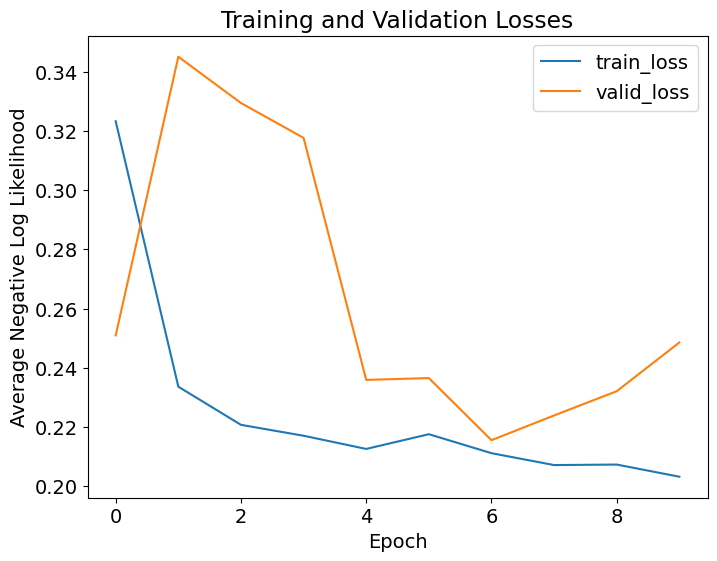

In [147]:
# Crea una nueva figura con tamaño 8x6
plt.figure(figsize=(8, 6))

# Itera sobre 'train_loss' y 'valid_loss'
for c in ['train_loss', 'valid_loss']:
    # Trazar la pérdida de entrenamiento o validación
    plt.plot(history[c], label=c)

# Agregar una leyenda al gráfico
plt.legend()

# Agregar nombres de los ejes
plt.xlabel('Epoch')  # Nombre del eje x
plt.ylabel('Average Negative Log Likelihood')  # Nombre del eje y

# Agregar título al gráfico
plt.title('Training and Validation Losses')

# Mostrar el gráfico
plt.show()

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

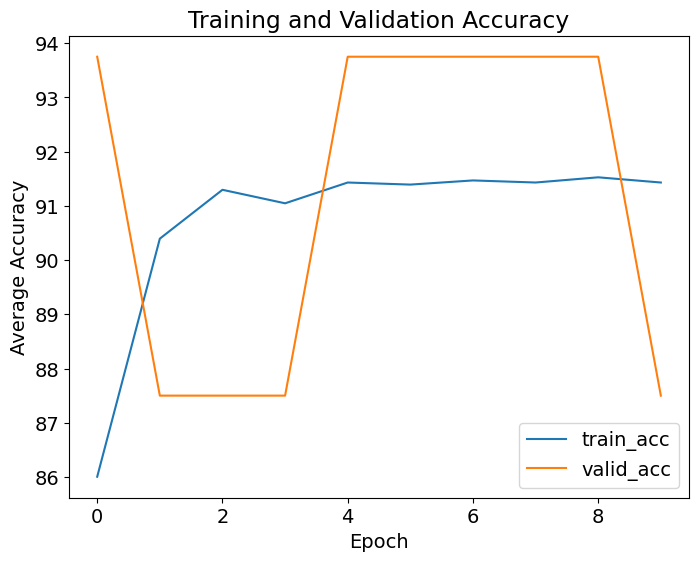

In [148]:
# Iniciamos una nueva figura con tamaño específico
plt.figure(figsize=(8, 6))

# Iteramos sobre las columnas 'train_acc' y 'valid_acc' de la historia de entrenamiento
for c in ['train_acc', 'valid_acc']:
    # Dibujamos cada una de estas columnas en el gráfico, multiplicadas por 100 para representarlas como porcentajes
    plt.plot(
        100 * history[c], label=c)
    
# Añadimos la leyenda al gráfico
plt.legend()

# Etiquetamos el eje x como 'Epoch'
plt.xlabel('Epoch')

# Etiquetamos el eje y como 'Average Accuracy'
plt.ylabel('Average Accuracy')

# Añadimos un título al gráfico
plt.title('Training and Validation Accuracy')

# Finalmente, mostramos el gráfico
plt.show()

7. Saving and loading the model

La función de entrenamiento guarda el mejor state_dict() del modelo, que son los pesos del modelo. Para guardar más información sobre el modelo, usamos la siguiente función. Tomaré en cuenta esta información.

In [149]:
def save_checkpoint(model, path):
    """Guarda un punto de control del modelo de PyTorch

    Parámetros
    --------
        model (PyTorch model): modelo para guardar
        path (str): ubicación para guardar el modelo. Debe comenzar con `model_name-` y terminar en '.pth'

    Retorna
    --------
        None, guarda el `model` en `path`
    """

    # Extrae el nombre del modelo del nombre de la ruta de archivo
    model_name = path.split('-')[0]
    # Asegúrese de que el nombre del modelo sea uno de los dos modelos que se espera
    assert (model_name in ['vgg16', 'resnet50']), "La ruta debe tener el nombre de modelo correcto"

    # Crea el diccionario que será guardado con detalles básicos
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Si el nombre del modelo es 'vgg16'
    if model_name == 'vgg16':
        # Comprueba si el modelo fue paralelizado
        if multi_gpu:
            # Si es así, guarda el clasificador y el estado del modelo del módulo
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            # Si no es así, guarda el clasificador y el estado del modelo directamente
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    # Si el nombre del modelo es 'resnet50'
    elif model_name == 'resnet50':
        # Comprueba si el modelo fue paralelizado
        if multi_gpu:
            # Si es así, guarda la capa completamente conectada y el estado del modelo del módulo
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            # Si no es así, guarda la capa completamente conectada y el estado del modelo directamente
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Agrega el optimizador y su estado al punto de control
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Guarda los datos en la ruta especificada
    torch.save(checkpoint, path)

In [150]:
# Llamando a la función save_checkpoint
# model: es el modelo entrenado que queremos guardar
# path: es la ubicación y el nombre del archivo en el que se guardará el modelo
save_checkpoint(model, path=checkpoint_path)

Cargando el modelo

In [151]:
def load_checkpoint(path):
    """Carga un punto de control de modelo de PyTorch

    Params
    --------
        path (str): punto de control del modelo guardado. Debe comenzar con `model_name-` y terminar en '.pth'

    Returns
    --------
        model (PyTorch model): modelo cargado desde el punto de control
        optimizer (PyTorch optimizer): optimizador cargado desde el punto de control

    """

    # Obtiene el nombre del modelo
    model_name = path.split('-')[0]
    # Asegura que el nombre del modelo sea correcto
    assert (model_name in ['vgg16'
                           ])

    # Carga el punto de control
    checkpoint = torch.load(path)

    # Carga el modelo correspondiente con pesos preentrenados
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Asegura que los parámetros no sean entrenables
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    # elif model_name == 'resnet50':
    #     model = models.resnet50(pretrained=True)
    #     # Asegura que los parámetros no sean entrenables
    #     for param in model.parameters():
    #         param.requires_grad = False
    #     model.fc = checkpoint['fc']

    # Carga el estado del modelo
    model.load_state_dict(checkpoint['state_dict'])

    # Imprime el total de parámetros y parámetros entrenables
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Mueve el modelo a la GPU si está disponible
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Básicos del modelo
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizador
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

# Carga el modelo y el optimizador desde el punto de control
model, optimizer = load_checkpoint(path=checkpoint_path)

# Imprime un resumen del modelo
if multi_gpu:
    summary(model.module, input_size=(3, 224, 224), batch_size=batch_size)
else:
    summary(model, input_size=(3, 224, 224), batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


135,309,890 total parameters.
1,049,346 total gradient parameters.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 224, 224]           1,792
              ReLU-2        [128, 64, 224, 224]               0
            Conv2d-3        [128, 64, 224, 224]          36,928
              ReLU-4        [128, 64, 224, 224]               0
         MaxPool2d-5        [128, 64, 112, 112]               0
            Conv2d-6       [128, 128, 112, 112]          73,856
              ReLU-7       [128, 128, 112, 112]               0
            Conv2d-8       [128, 128, 112, 112]         147,584
              ReLU-9       [128, 128, 112, 112]               0
        MaxPool2d-10         [128, 128, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]         295,168
             ReLU-12         [128, 256, 56, 56]               0
           Conv2d-13         [128, 2

7. Making Predictions

Ahora se prueba el modelo y se evalua el Model sobre todas las clases.

In [154]:
# Cargamos los datos de prueba en 'test_loader'
test_loader=dataloaders['test']

# Inicializamos las variables que vamos a usar para calcular la pérdida total y la precisión
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

# Definimos las clases posibles en nuestro problema de clasificación
classes = [0,1]

# Cambiamos el modelo a modo de evaluación. Esto es necesario ya que algunas capas como Dropout o BatchNorm
# tienen un comportamiento distinto durante el entrenamiento y durante la evaluación.
model.eval()

# Iteramos sobre los datos de prueba
for data, target in test_loader:
    
    # Si el tamaño del lote no es igual a 'batch_size', continuamos con la próxima iteración
    if len(target)!=batch_size:
        continue

    # Si disponemos de GPU, movemos los tensores a la GPU
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    # Realizamos la pasada hacia adelante a través del modelo para obtener las predicciones
    output = model(data)

    # Calculamos la pérdida de este lote de datos de prueba
    loss = criterion(output, target)

    # Actualizamos la pérdida total de prueba
    test_loss += loss.item()*data.size(0)

    # Convertimos las probabilidades de salida del modelo en la clase predicha
    _, pred = torch.max(output, 1)    

    # Comparamos las predicciones con las etiquetas verdaderas
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    # Calculamos la precisión de prueba para cada clase
    for i in range(batch_size):       
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# Calculamos la pérdida media de prueba
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Imprimimos la precisión de prueba para cada clase y en general
for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Test Loss: 0.448449

Test Accuracy of     0: 54% (104/190)
Test Accuracy of     1: 95% (306/322)

Test Accuracy (Overall): 80% (410/512)


In [155]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Inicializamos las listas para almacenar las verdaderas etiquetas y las predicciones
y_true = []
y_pred = []

# Iteramos sobre los datos de prueba
for data, target in test_loader:
    if len(target) != batch_size:
        continue

    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    _, pred = torch.max(output, 1)

    y_true.extend(target.data.view_as(pred).cpu().numpy())
    y_pred.extend(pred.cpu().numpy())

# Convertimos las listas a arrays de numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculamos la precisión, recall y F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1-score: {:.2f}'.format(f1_score))

# Calculamos y mostramos la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(cm)

Precision: 0.75
Recall: 0.95
F1-score: 0.84
Confusion Matrix:
[[107  96]
 [ 16 293]]


### ***ResNet***

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [109]:

# Configuramos las transformaciones para los conjuntos de datos de entrenamiento, prueba y validación
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Cargamos los conjuntos de datos de entrenamiento, prueba y validación
data_dir = '/content/drive/MyDrive/chest_xray/chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Configuramos el dispositivo en el que vamos a entrenar nuestro modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Cargamos el modelo preentrenado
model = models.resnet50(pretrained=True)

# Congelamos los parámetros del modelo para que no se actualicen durante el proceso de entrenamiento
for param in model.parameters():
    param.requires_grad = False

# Modificamos la última capa del modelo para adaptarla a nuestro problema de clasificación binaria
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [110]:
# Enviamos el modelo al dispositivo
model = model.to(device)

# Definimos la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.01)

In [111]:
# Definición de la función de entrenamiento
def train_model(model, criterion, optimizer, train_loader, valid_loader, save_file_name, max_epochs_stop=3, n_epochs=20, print_every=2):
    # Rastreadores de rendimiento
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Listas para los valores medios de pérdida y precisión de entrenamiento y validación
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    try:
        print(f'Modelo ha sido entrenado por {model.epochs} épocas.')
    except:
        model.epochs = 0
        print(f'A partir del entrenamiento desde cero.')

    for epoch in range(n_epochs):

        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        ii = 0

        for data, label in train_loader:
            ii += 1
            data, label = data.to(device), label.to(device)

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, label)
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * data.size(0)

            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(label.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * data.size(0)

        with torch.no_grad():
            model.epochs += 1

            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)

                output = model(data)

                loss = criterion(output, label)
                valid_loss += loss.item() * data.size(0)

                ret, predictions = torch.max(output.data, 1)
                correct_counts = predictions.eq(label.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * data.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)

        train_acc = train_acc / len(train_loader.dataset)
        valid_acc = valid_acc / len(valid_loader.dataset)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        history.append([train_loss, valid_loss, train_acc, valid_acc])

        if (epoch + 1) % print_every == 0:
            print(
                f'\nÉpoca: {epoch} \tEntrenamiento Pérdida: {train_loss:.4f} \tValidación Pérdida: {valid_loss:.4f}'
            )
            print(
                f'\t\tEntrenamiento Precisión: {100 * train_acc:.2f}%\t Validación Precisión: {100 * valid_acc:.2f}%'
            )

        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_file_name)
            epochs_no_improve = 0
            valid_loss_min = valid_loss
            valid_best_acc = valid_acc
            best_epoch = epoch

        else:
            epochs_no_improve += 1

        if epoch > 5 and epochs_no_improve == max_epochs_stop:
            print(f'\nEntrenamiento temprano detenido en la época {epoch}!')
            model.load_state_dict(torch.load(save_file_name))
            model.optimizer = optimizer

            history = pd.DataFrame(
                history,
                columns=[
                    'train_loss', 'valid_loss', 'train_acc',
                    'valid_acc'
                ])
            return model, history, train_losses, valid_losses, train_accs, valid_accs

    model.optimizer = optimizer
    print(f'\nEntrenamiento finalizado en la época: {epoch}.')

    history = pd.DataFrame(
        history,
        columns=[
            'train_loss', 'valid_loss', 'train_acc',
            'valid_acc'
        ])
    return model, history, train_losses, valid_losses, train_accs, valid_accs

In [116]:
# Entrenamiento del modelo
model, history, train_losses, valid_losses, train_accs, valid_accs = train_model(
    model, criterion, optimizer, dataloaders['train'], dataloaders['val'],
    save_file_name='model.pt', max_epochs_stop=10, n_epochs=20, print_every=1)

A partir del entrenamiento desde cero.

Época: 0 	Entrenamiento Pérdida: 0.7044 	Validación Pérdida: 0.7252
		Entrenamiento Precisión: 46.66%	 Validación Precisión: 43.75%

Época: 1 	Entrenamiento Pérdida: 0.7063 	Validación Pérdida: 0.7121
		Entrenamiento Precisión: 45.80%	 Validación Precisión: 50.00%

Época: 2 	Entrenamiento Pérdida: 0.7064 	Validación Pérdida: 0.7093
		Entrenamiento Precisión: 45.82%	 Validación Precisión: 50.00%

Época: 3 	Entrenamiento Pérdida: 0.7068 	Validación Pérdida: 0.7118
		Entrenamiento Precisión: 45.40%	 Validación Precisión: 31.25%

Época: 4 	Entrenamiento Pérdida: 0.7060 	Validación Pérdida: 0.6910
		Entrenamiento Precisión: 46.09%	 Validación Precisión: 43.75%

Época: 5 	Entrenamiento Pérdida: 0.7054 	Validación Pérdida: 0.6856
		Entrenamiento Precisión: 46.99%	 Validación Precisión: 62.50%

Época: 6 	Entrenamiento Pérdida: 0.7054 	Validación Pérdida: 0.7094
		Entrenamiento Precisión: 46.28%	 Validación Precisión: 37.50%

Época: 7 	Entrenamiento Pérdi

In [117]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            all_predictions.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    all_predictions = torch.tensor(all_predictions).to(device)
    all_labels = torch.tensor(all_labels).to(device)

    test_recall = recall_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')
    test_precision = precision_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')
    test_f1 = f1_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')

    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test F1-score: {test_f1:.4f}')

    # Obtener la matriz de confusión
    cm = confusion_matrix(all_labels.cpu().numpy(), all_predictions.cpu().numpy())
    print('Confusion Matrix:')
    print(cm)

    # Graficar la matriz de confusión
    class_names = test_loader.dataset.classes
    plot_confusion_matrix(cm, classes=class_names)
    plt.show()

Test Loss: 0.7496
Test Accuracy: 0.3478
Test Recall: 0.3478
Test Precision: 0.3956
Test F1-score: 0.3105
Confusion Matrix:
[[153  81]
 [326  64]]


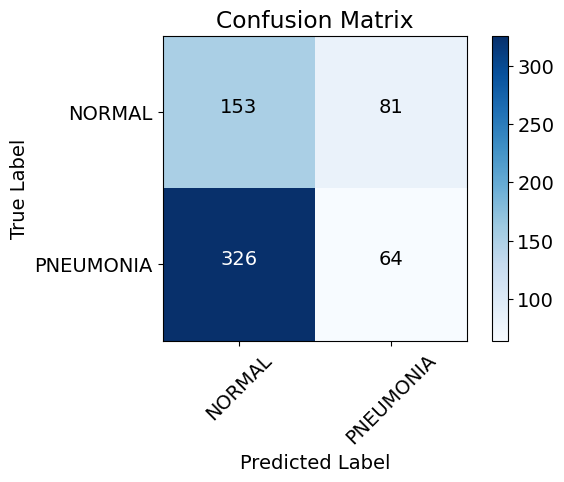

In [119]:
# Evaluar el modelo ResNet en el conjunto de prueba
evaluate_model(model, test_loader, criterion)

### ***GoogleNet***

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

In [103]:
# Definir transformaciones de datos
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Definir directorio de datos
data_dir = '/content/drive/MyDrive/chest_xray/chest_xray'

# Cargar conjuntos de datos
image_datasets = {
    x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Crear generadores de datos
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val', 'test']
}

# Obtener el número de clases
num_classes = len(image_datasets['train'].classes)

# Configurar el dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Cargar el modelo GoogLeNet preentrenado
model = models.googlenet(pretrained=True)

# Reemplazar la capa de clasificación
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Mover el modelo al dispositivo
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [104]:
# Función de entrenamiento
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model

In [105]:
# Entrenar el modelo
trained_model = train_model(model, criterion, optimizer, dataloaders['train'], dataloaders['val'], num_epochs=10)

Epoch 1/10
----------
Train Loss: 0.3224, Train Acc: 0.8669
Val Loss: 0.3523, Val Acc: 0.7500

Epoch 2/10
----------
Train Loss: 0.2687, Train Acc: 0.8959
Val Loss: 1.2154, Val Acc: 0.6875

Epoch 3/10
----------
Train Loss: 0.2590, Train Acc: 0.9043
Val Loss: 0.3794, Val Acc: 0.8750

Epoch 4/10
----------
Train Loss: 0.2318, Train Acc: 0.9160
Val Loss: 0.3371, Val Acc: 0.8125

Epoch 5/10
----------
Train Loss: 0.2096, Train Acc: 0.9248
Val Loss: 0.4151, Val Acc: 0.7500

Epoch 6/10
----------
Train Loss: 0.2038, Train Acc: 0.9296
Val Loss: 0.3671, Val Acc: 0.8125

Epoch 7/10
----------
Train Loss: 0.1937, Train Acc: 0.9350
Val Loss: 0.3761, Val Acc: 0.7500

Epoch 8/10
----------
Train Loss: 0.1841, Train Acc: 0.9327
Val Loss: 0.8768, Val Acc: 0.6250

Epoch 9/10
----------
Train Loss: 0.1626, Train Acc: 0.9438
Val Loss: 0.3096, Val Acc: 0.8125

Epoch 10/10
----------
Train Loss: 0.1724, Train Acc: 0.9411
Val Loss: 0.5703, Val Acc: 0.6250



In [106]:
import itertools

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            test_corrects += torch.sum(preds == labels.data)

            all_predictions.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_corrects.double() / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    all_predictions = torch.tensor(all_predictions).to(device)
    all_labels = torch.tensor(all_labels).to(device)

    test_recall = recall_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')
    test_precision = precision_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')
    test_f1 = f1_score(all_labels.cpu().numpy(), all_predictions.cpu().numpy(), average='weighted')

    print(f'Test Recall: {test_recall:.4f}')
    print(f'Test Precision: {test_precision:.4f}')
    print(f'Test F1-score: {test_f1:.4f}')

    # Obtener la matriz de confusión
    cm = confusion_matrix(all_labels.cpu().numpy(), all_predictions.cpu().numpy())
    print('Confusion Matrix:')
    print(cm)

    # Graficar la matriz de confusión
    class_names = image_datasets['train'].classes
    plot_confusion_matrix(cm, classes=class_names)
    plt.show()

Test Loss: 0.2461
Test Accuracy: 0.9199
Test Recall: 0.9199
Test Precision: 0.9272
Test F1-score: 0.9177
Confusion Matrix:
[[186  48]
 [  2 388]]


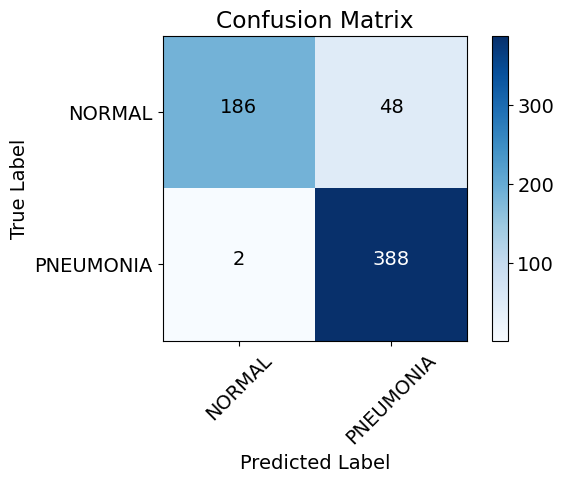

In [107]:
# Evaluar el modelo en el conjunto de prueba e imprimir las métricas y la matriz de confusión
test_model(trained_model, dataloaders['test'], criterion)